In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import os
import sys
from tqdm import tqdm

sys.path.append('../../ieegpy/ieeg')
sys.path.append('code/tools')
sys.path.append('code')
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# sets path to one directory up from where code is
path = "/".join(os.path.abspath(os.getcwd()).split('/')[:-1])

import json
import numpy as np
import pandas as pd
from get_iEEG_data import get_iEEG_data
from plot_iEEG_data import plot_iEEG_data
from line_length import line_length
from get_iEEG_duration import get_iEEG_duration
import csv_utils
import segmentation
import feature_extraction
import preprocess

In [3]:
with open("credentials.json") as f:
    credentials = json.load(f)
    username = credentials['username']
    password = credentials['password']

In [4]:
metadata = pd.read_csv('ieeg_metadata.csv')
metadata.describe()

,Unnamed: 0,Seizure number,Seizure EEC,Seizure UEO,Seizure end,Seizure duration
count,256.000000,256.000000,2.560000e+02,2.560000e+02,2.560000e+02,256.000000
mean,161.523438,3.808594,3.850046e+05,3.850087e+05,3.850987e+05,89.983726
std,105.468253,4.411047,2.512188e+05,2.512184e+05,2.512276e+05,107.030035
min,0.000000,0.000000,1.422600e+04,1.422600e+04,1.425995e+04,4.900000
25%,64.750000,1.000000,2.076900e+05,2.076916e+05,2.077277e+05,34.252500
50%,155.500000,2.000000,3.487700e+05,3.487708e+05,3.490025e+05,67.945000
75%,255.250000,5.000000,5.301436e+05,5.301436e+05,5.302733e+05,91.760000
max,364.000000,22.000000,1.694568e+06,1.694570e+06,1.694644e+06,781.950000


In [5]:
seizure_data = csv_utils.read_pickle('data/seizure/seizure_clips_data', 256)
seizure_time = csv_utils.read_pickle('data/seizure_time/seizure_time_data', 256)
for i in range(len(seizure_data)):
    seizure_data[i] = seizure_data[i].dropna(axis='columns')

In [6]:
nonseizure_data = csv_utils.read_pickle('data/non_seizure/nonseizure_clips_data', 256)
nonseizure_time = csv_utils.read_pickle('data/non_seizure_time/nonseizure_time_data', 256)
for i in range(len(nonseizure_data)):
    nonseizure_data[i] = nonseizure_data[i].dropna(axis='columns')

In [7]:
# seizure_data,seizure_time = csv_utils.seizure_clip_read(metadata, username, password)
# csv_utils.dump_pickle(seizure_data,'data/seizure/seizure_clips_data')
# csv_utils.dump_pickle(seizure_time,'data/seizure_time/seizure_time_data')

In [8]:
# nonseizure_data, nonseizure_time = csv_utils.nonseizure_clip_read(metadata, username, password)
# csv_utils.dump_pickle(nonseizure_data,'data/non_seizure/nonseizure_clips_data')
# csv_utils.dump_pickle(nonseizure_time,'data/non_seizure_time/nonseizure_time_data')

In [9]:
window_len = 2
stride = 1
seizure_data_windowed = []
for i in tqdm(range(len(seizure_data))):
    fs = segmentation.get_fs(seizure_time[i])
    if fs == 512:
        seg = segmentation.get_windoweds(seizure_data[i].to_numpy(), fs, window_len, stride)
        seizure_data_windowed.append(seg)
window_len = 2
stride = 1
nonseizure_data_windowed = []
for i in tqdm(range(len(nonseizure_data))):
    fs = segmentation.get_fs(nonseizure_time[i])
    if fs == 512:
        seg = segmentation.get_windoweds(nonseizure_data[i].to_numpy(), fs, window_len, stride)
        nonseizure_data_windowed.append(seg)

100%|██████████| 256/256 [01:10<00:00,  3.64it/s]


In [10]:
seizure_data_windowed[1].shape

(78, 1024, 82)

In [32]:
channel_n = 90
fs = 512
seizure_data_stack = np.empty((0, fs * 2, channel_n))
for c in seizure_data_windowed:
    if c.shape[2] == channel_n:
        seizure_data_stack = np.vstack((seizure_data_stack, c))
for c in nonseizure_data_windowed:
    if c.shape[2] == channel_n:
        seizure_data_stack = np.vstack((seizure_data_stack, c))

In [34]:
seizure_data_stack.shape

(2192, 1024, 90)

In [13]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, BatchNormalization,GlobalAveragePooling2D, Input, Reshape, UpSampling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.optimizers import schedules, SGD, Adam
import tensorflow as tf
from sklearn import preprocessing
from matplotlib import pyplot as plt

In [35]:
from autoencoder import Autoencoder
ae = Autoencoder(seizure_data_stack.shape[1],seizure_data_stack.shape[2])

In [36]:
dg_min, dg_max = preprocess.normalization_fit_stack(seizure_data_stack)
seizure_data_norm = preprocess.normalize_stack(seizure_data_stack,dg_min,dg_max)

In [38]:
ae.build(input_shape = (None,seizure_data_norm.shape[1],seizure_data_norm.shape[2]))
ae.summary()
ae.compile(optimizer='adam', loss='mae')
ae.fit(seizure_data_norm, seizure_data_norm,
          epochs=5,
          batch_size=64,
          validation_data=(seizure_data_norm, seizure_data_norm))

Model: "autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 64, 1, 64)         8160      
                                                                 
 sequential_3 (Sequential)   (None, 1024, 90)          10433     
                                                                 
Total params: 18,593
Trainable params: 18,209
Non-trainable params: 384
_________________________________________________________________
Epoch 1/5
35/35 [==============================] - 161s 5s/step - loss: 0.0397 - val_loss: 0.2788
Epoch 2/5
35/35 [==============================] - 164s 5s/step - loss: 0.0254 - val_loss: 0.2576
Epoch 3/5
35/35 [==============================] - 158s 5s/step - loss: 0.0242 - val_loss: 0.2387
Epoch 4/5
35/35 [==============================] - 158s 5s/step - loss: 0.0234 - val_loss: 0.1933
Epoch 5/5
35/35 [==============================] - 

In [44]:
ae.encoder.save("encoder.h5")
ae.decoder.save("decoder.h5")

In [56]:
encode = ae.encoder.predict(seizure_data_norm)
decode = ae.decoder.predict(encode)

69/69 [==============================] - 11s 156ms/step


In [57]:
decode.shape

(2192, 1024, 90)

In [87]:
from sklearn.metrics import mean_squared_error
mean_squared_error(seizure_data_norm[3], decode[3])

0.028935761681124536

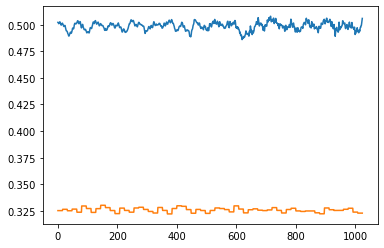

In [81]:
plt.plot(seizure_data_norm[6,:,5])
plt.plot(decode[6,:,5])

In [69]:
decode[0].max()

0.33884054

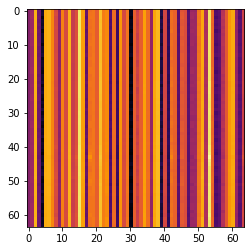

In [52]:
plt.imshow(encode[0], cmap='inferno')
plt.show()

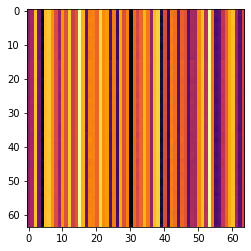

In [54]:
plt.imshow(encode[1097], cmap='inferno', interpolation='nearest')
plt.show()